# MATH 405/607 

# Numerical Methods for Differential Equations

[[Instructor: Christoph Ortner]](http://www.math.ubc.ca/~ortner/) <!--  [[CANVAS]](https://canvas.ubc.ca/courses/55324) -->

## Preview: Solving a 1D Boundary Value Problem


In [1]:
include("math405.jl")

  Activating project at `~/gits/math405/notes`


### The simplest boundary value problem:

$$\begin{aligned}
- u''(x) + r(x) u(x) &= f(x), \qquad x \in (0, 1) \\ 
  u(0) &= u_0, \\ 
  u(1) &= u_1
\end{aligned}$$

- Does a solution exist? 
- Under which conditions on $r, f$ does a solution exist?
- Is it unique? Stable under perturbations of $r, f$?

Although these questions are not the focus of this course, they are still intimately linked to numerical computing hence we will occasionally discuss them. But for now let us assume that $r, f$ are sufficiently "nice" that a smooth solution $u$ exists.

- How do we compute it?

We can make our life particularly easy, 

$$\begin{aligned}
- u''(x) + u(x) &= 1, \qquad x \in (0, 1) \\ 
  u(0) &= 0, \\ 
  u(1) &= 0
\end{aligned}$$

Then we can readily check that the following is a solution:

$$
   u(x) = 1 - \frac{e^x + e^{1-x}}{1+e}
$$

* Question: Why can we get such a simple analytic solution?
* Challenge: is it unique? If yes, provide a proof; if not, provide a counterexample.

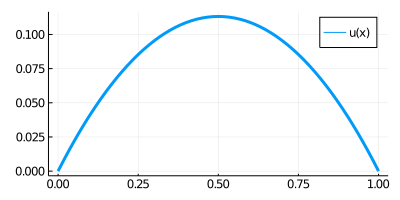

In [2]:
# Plotting the solution 
u(x) = 1 -  (exp(x) + exp(1-x)) / (1 + MathConstants.e)
plot(u, 0, 1, lw=3, label = "u(x)", size = (400, 200))

### Discretising the solution 

We cannot store $u$ in a computer (infinite information), but we could store it (or an approximation) at finitely many points, 

$$
        x_n = n/N, \qquad n = 0, \dots, N.
$$

which are called nodes, mesh, or grid points, etc.
We call $h = 1/N$ the mesh-size or grid-size. We can evaluate $U_n = u(x_n)$ which give us a discretisation of the the solution.

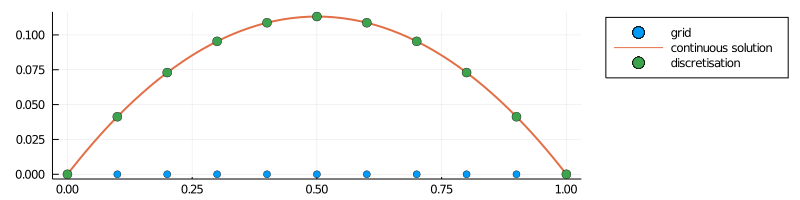

In [3]:
N = 10; X = range(0, 1, length=N+1)
scatter(X, 0*X, size = (600, 80), label = "grid")
plot!(u, 0, 1, lw=2, label = "continuous solution")
scatter!(X, u.(X), ms=5, label = "discretisation", size = (800, 200), legend=:outertopright)

### Discretising the equation 

But what if we don't know the solution explicitly? This is the *typical* scenario!

The idea is to devise an equation for the *discretised solution*. The first step is to evaluate the equation only at the nodes 

$$
   - u''(x_n) + r(x_n) u(x_n) = f(x_n) 
$$

By evaluating the data $f, r$ at the nodes, $F_n = f(x_n)$ and $R_n = r(x_n)$, we obtain 

$$
  - u''(x_n) + R_n U_n = F_n
  $$
  
What to do about $u''(x_n)$?

### Finite Difference Approximation

Taylor expansion:

$$
    u(x+h) = u(x) + h u'(x) + \frac{h^2}{2} u''(x) + \frac{h^3}{6} u'''(x) + \frac{h^4}{24} u^{(iv)}(\xi)
$$

From this we can deduce, e.g., 

$$\begin{aligned}
    \frac{u(x+h) - u(x)}{h} &= u'(x) + \frac{h}{2} u''(x) + \dots \\ 
    \frac{u(x+h) - 2u(x) + h(x-h)}{h^2} &=  u''(x) + O(h^2)
\end{aligned}$$

Can we replace $u''$ with its FD approximation?

This gives us

$$
    - \frac{u(x_n+h) - 2 u(x_n) + u(x_{n}-h)}{h^2} + r(x_n) u(x_n) = f(x_n), 
$$

But if we choose $h = 1/N$ (we did) then $u(x_n \pm h) = U_{n \pm 1}$, so we can write  a linear system for the *unknowns* $U_n$, $n = 0, \dots, N$:

$$\begin{aligned}
    - \frac{U_{n+1} - 2 U_n + U_{n-1}}{h^2} + R_n U_n  &= F_n, \quad n = 1, \dots, N-1, \\ 
    U_0 &= u_0, \\ 
    U_1 &= u_1.
\end{aligned}$$

(Note for the toy model we just have $u_0 = u_1 = 0, R_n = F_n = 1$.)

### Implementation of the FD Scheme

<!-- $$
\frac{1}{h^2} \begin{pmatrix}
    h^2 &  &  &  &        \\
    -1 & 2 + h^2 & -1  &  &      \\
       & -1 & 2 + h^2 & -1  &     \\
       &    &  \ddots & \ddots & \ddots
\end{pmatrix}
 \cdot 
 \begin{pmatrix}
        U_0 \\ U_1 \\ U_2 \\ \vdots
 \end{pmatrix}
 = 
 \begin{pmatrix}
     0 \\ 1 \\ 1 \\ \vdots 
 \end{pmatrix}
$$
-->

$$
\begin{pmatrix}
    1 &  &  &  &        \\
    - h^{-2} & 2 h^{-2} + 1 & - h^{-2}  &  &      \\
       & -h^{-2} & 2 h^{-2} + 1 & - h^{-2}  &     \\
       &    &  \ddots & \ddots & \ddots
\end{pmatrix}
 \cdot 
 \begin{pmatrix}
        U_0 \\ U_1 \\ U_2 \\ \vdots
 \end{pmatrix}
 = 
 \begin{pmatrix}
     0 \\ 1 \\ 1 \\ \vdots 
 \end{pmatrix}
$$

after eliminating the first and last row (which are trivia) we get the following system:

$$
\begin{pmatrix}
       2 h^{-2} + 1 & - h^{-2}  &  &      \\
       -h^{-2} & 2 h^{-2} + 1 & - h^{-2}  &     \\
          &  \ddots & \ddots & \ddots
\end{pmatrix}
 \cdot 
 \begin{pmatrix}
        U_1 \\ U_2 \\ \vdots
 \end{pmatrix}
 = 
 \begin{pmatrix}
      1 \\ 1 \\ \vdots 
 \end{pmatrix}
$$

$$
\begin{pmatrix}
       2 h^{-2} + 1 & - h^{-2}  &  &      \\
       -h^{-2} & 2 h^{-2} + 1 & - h^{-2}  &     \\
          &  \ddots & \ddots & \ddots
\end{pmatrix}
 \cdot 
 \begin{pmatrix}
        U_1 \\ U_2 \\ \vdots
 \end{pmatrix}
 = 
 \begin{pmatrix}
      1 \\ 1 \\ \vdots 
 \end{pmatrix}
$$

... which we can now implement:

In [4]:
function assemble_fd(N)
    h = 1/N
    F = ones(N-1)
    A = Tridiagonal( - ones(N-2) / h^2 , 
                     (2/h^2+1)*ones(N-1),
                     - ones(N-2) / h^2 )
    return A, F 
end

assemble_fd (generic function with 1 method)

In [5]:
N = 10 
A, F =  assemble_fd(10)
display(A)
display(F)

9×9 Tridiagonal{Float64, Vector{Float64}}:
  201.0  -100.0      ⋅       ⋅       ⋅       ⋅       ⋅       ⋅       ⋅ 
 -100.0   201.0  -100.0      ⋅       ⋅       ⋅       ⋅       ⋅       ⋅ 
     ⋅   -100.0   201.0  -100.0      ⋅       ⋅       ⋅       ⋅       ⋅ 
     ⋅       ⋅   -100.0   201.0  -100.0      ⋅       ⋅       ⋅       ⋅ 
     ⋅       ⋅       ⋅   -100.0   201.0  -100.0      ⋅       ⋅       ⋅ 
     ⋅       ⋅       ⋅       ⋅   -100.0   201.0  -100.0      ⋅       ⋅ 
     ⋅       ⋅       ⋅       ⋅       ⋅   -100.0   201.0  -100.0      ⋅ 
     ⋅       ⋅       ⋅       ⋅       ⋅       ⋅   -100.0   201.0  -100.0
     ⋅       ⋅       ⋅       ⋅       ⋅       ⋅       ⋅   -100.0   201.0

9-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

### Solution of the linear system 

To solve `A * U = F` we use a black box solver provided by Julia, which can be invoked via 
```
U = A \ F
```
Note how the `\` indicates division i.e. $A^{-1} F$. 
We will revisit linear solvers in the next lecture. For now, only note that Julia solves the linear system without ever evaluating $A^{-1}$. Indeed, this should (almost) *NEVER* be done.

In our current specific case the algorithm used by Julia (LU factorisation) requires only $O(N)$ operations. This is quasi-optimal! Such optimal scaling algorithms are one of the key goals of numerical analysis and scientific computing.

In [6]:
u1 = inv(A) * F   # never do this!!!  (without thinking very very carefully)
u2 = A \ F 
u1 ≈ u2

true

Error: 8.527105230655974e-5; this is very good!


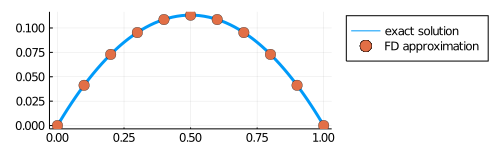

In [7]:
N = 10 
A, F = assemble_fd(N)
U = [ [0.0]; A \ F; [0.0] ]   # this does NOT compute A^{-1} and then multiplies A^{-1} *  F

X = range(0, 1, length=N+1)
plot(u, 0, 1, lw=3, label = "exact solution", size = (500, 150), legend = :outertopright)
scatter!(X, U, marker = :dot, ms=6, lw=2, ls=:dash, label = "FD approximation")
maxerr = norm(u.(X) - U, Inf)
println("Error: $(maxerr); this is very good!")
plot!()

### Error Analysis

We have changed 
- how we represent the solution: a discrete set of points instead of a continuous function;
- how we represent the equation: a finite-difference equation instead of a differential equation.

Naturally, the question arises in what sense we can talk about error, and what that error is. This is one of the major topics of numerical analysis and scientific computing.

In our last computational experiment we have implicitly adopted a seemingly sensible notion of error of our finite-difference solution. And we have shown that it is *remarkably* accurate; ca. 0.1% error which is already far better than typical engineering accuracy. Can we explain this?

We will later learn how to prove the following result:

**Theorem:** Let $r > 0$ then 
$$
    \max_{n = 0, \dots, N} |U_n - u(x_n)| \leq \frac{h^2}{96} \| u^{(4)} \|_{\infty}         
$$


But we should now also confirm numerically that our result is (i) correct; and (ii) sharp. With a little bit of basic calculus we can show that $\|u^{(iv)}\|_\infty = 1$. Therefore the estimate becomes $\|E\|_\infty \leq h^2 / 96$.

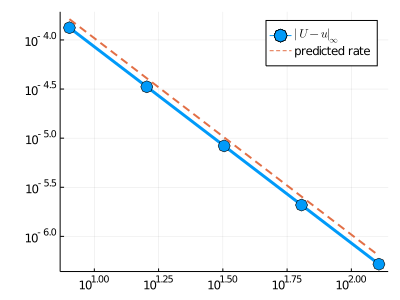

In [8]:
get_maxerr(N) = norm( u.(range(0, 1,length=N+1)) - [[0.0]; \(assemble_fd(N)...); [0.0]], Inf )

NN = [8, 16, 32, 64, 128]
plot( NN, get_maxerr.(NN), lw=3, m=:o, ms=6, label = L"\| U - u \|_\infty", 
      xaxis = :log, yaxis = :log, size=(400,300))
plot!( NN, NN.^(-2) / 96, lw=2, ls=:dash, label = "predicted rate" )

### Things can also go wrong (1)

Consider an Advection-diffusion problem

$$\begin{aligned}
    - 0.01 u''(x) + u'(x) = 1, \quad u(0) = u(1) = 0
\end{aligned}$$

discretised via 

$$
    - 0.01 \frac{U_{n+1} - 2 U_n + U_{n-1}}{h^2} + \frac{U_{n+1} - U_{n-1}}{2h} = 1
$$


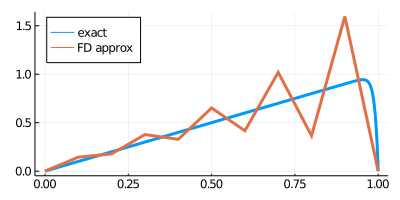

In [9]:
N = 10; epsn = 0.01; o = ones(N-1)
F = [ [0.0]; o; [0.0] ]
A = Tridiagonal( [ (-epsn*N^2 - 0.5*N) * o; [0.0] ], 
                 [ [1.0]; (2*epsn*N^2) * o; [1.0] ],
                 [ [0.0]; (- epsn*N^2 + 0.5*N) * o] )
plot(x -> x - (exp(x/0.01)-1)/(exp(1/0.01)-1), 0, 1, lw=3, label = "exact", legend = :topleft)
plot!(range(0, 1, length=N+1), A \ F, lw=3, ms=5, label ="FD approx", size=(400,200))

### Things can also go wrong (2)

A parabolic / diffusion / heat equation; now $u = u(t, x)$ solves 

$$
    u_t - u_{xx} = 0, \qquad u(0, x) = x (1-x)
$$

Discretised by $U_n^j \approx u(t_j, x_n)$, 
$$
    \frac{U_n^{j+1} - U_n^j}{k} - \frac{U_{n+1}^j - 2 U_n^j + U_{n-1}^j}{h^2} = 0
$$
cf. L09!

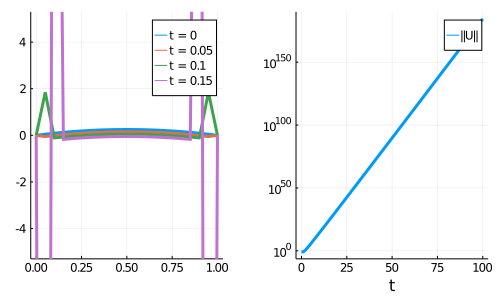

In [10]:
N = 20; o = ones(N-1); X = range(0, 1, length=N+1)
A = Tridiagonal( [N^2*o; [0.0]], [[1.0]; -2*N^2*o; [1.0]], [[0.0]; N^2*o] )
U = X .* (1 .- X)
k = 1/N   # same step in time and space (we will later learn this is a bad idea!)
p1 = plot(X, U, lw=3, label = "t = 0", yaxis = ([-5, 5],))
maxU = [ norm(U, Inf) ]
for j = 1:100
    U += k * (A * U)
    if j <= 3; plot!(p1, X, U, lw=3, label = "t = $(round(j*k,digits=2))"); end 
    push!(maxU, norm(U, Inf))
end
plot(p1, plot(0:100, maxU, lw=3, label="||U||", xlabel = "t", yaxis = :log), size = (500, 300))

# Things can also go horribly wrong

Time-dependent convection with periodic boundary conditions, 

$$
    u_t + u_{x} = 0, \qquad u(t, 0) = u(t, 1), \qquad u(0, x) = \sin(x)
$$

Discretised by $U_n^j \approx u(t_j, x_n)$, 
$$
    \frac{U_n^{j+1} - U_n^j}{k} + \frac{U_{n+1}^j - U_n^j}{h} = 0
$$
Cf. L10!

┌ Info: Saved animation to 
│   fn = /Users/ortner/gits/math405/notes/tmp.gif
└ @ Plots /Users/ortner/.julia/packages/Plots/shY1Z/src/animation.jl:104


Plots.AnimatedGif("/Users/ortner/gits/math405/notes/tmp.gif")
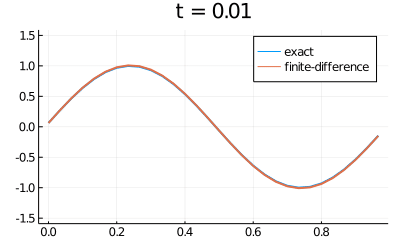

In [11]:
# spatial discretisation
N = 30; X = range(0, 1-1/N, length=N);   
A = diagm( -1 => -N * ones(N-1), 0 => N * ones(N), N-1 => [-N] )
U = sin.(2*pi*X)   # initial condition 
k = 0.3/N          # timestep 

plot(X, U, lw=3, label = "t = 0", yaxis = ([-5, 5],))
gif = @gif for j = 1:150
    global U
    U += k * (A * U)
    plot(X, sin.(2*pi*(X .+ k*j)), label = "exact", lw=2, size=(400, 250))
    plot!(X, U, yaxis = ([-1.5, 1.5],), lw=2,  
          title = "t = $(round(k*j, digits=2))", 
          label = "finite-difference")
end 

Some other equations we may want to solve: 

* Systems of ODEs
$$
   \dot{u} = F(u)
$$

* Nonlinear advection (Burgers equations)
$$
   u_t + u u_x = 0  
$$

* Nonlinear elasticity (or a 1d version thereof...)
$$
    ( \sigma(u_x) )_x = f 
$$

* A calculus of variations problem: (Brachistochrone)
$$
    u = \arg\min \int_0^1 \sqrt{1 + u_x^2} \,dx
$$

We will need some additional tools to solve all of these, including quadrature, nonlinear solvers, etc... 